In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
kaggle = False  

In [0]:
if kaggle:
  # This Python 3 environment comes with many helpful analytics libraries installed
  # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
  # For example, here's several helpful packages to load in 

  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

  # Input data files are available in the "../input/" directory.
  # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

  import os
  for dirname, _, filenames in os.walk('/kaggle/input'):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  # Any results you write to the current directory are saved as output.

In [4]:
if not kaggle:
  !pip install kaggle
  from getpass import getpass
  import os
  user = 'ahmadelsallab'
  key = '6b7ffe97ff5bc0656e325b746b72fa31'

  if '.kaggle' not in os.listdir('/root'):
      !mkdir ~/.kaggle
  !touch /root/.kaggle/kaggle.json
  !chmod 666 /root/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as f:
      f.write('{"username":"%s","key":"%s"}' % (user, key))
  !chmod 600 /root/.kaggle/kaggle.json

  !kaggle competitions download -c ashrae-energy-prediction

  !unzip -n train.csv.zip
  !unzip -n weather_train.csv.zip
  !unzip -n building_metadata.csv.zip

weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
Archive:  weather_train.csv.zip
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


In [19]:

def load_train_data():
  if kaggle:
    train_path = '/kaggle/input/ashrae-energy-prediction/train.csv'
    building_train_path = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
    weather_train_path = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
  else:
    train_path = 'train.csv'
    building_train_path = 'building_metadata.csv'
    weather_train_path = 'weather_train.csv'

  return pd.merge(pd.merge(pd.read_csv(train_path), pd.read_csv(building_train_path), on='building_id', how='left'), pd.read_csv(weather_train_path), on=['timestamp','site_id'], how='left')
train_df = load_train_data()
train_df.head()
  

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [21]:
train_df.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [0]:

train_df.meter_reading = train_df.meter_reading.apply(np.log1p)

In [0]:
train_df.square_feet = train_df.square_feet.apply(np.log1p)

In [0]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type != '<M8[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [10]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 713.72 MB
Decreased by 72.8%


In [11]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float16,0,8494,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,float16,0,568,8.91406,7.91016,8.59375
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


In [0]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["day"] = train_df["timestamp"].dt.day
train_df["weekday"] = train_df["timestamp"].dt.weekday_name 
train_df["month"] = train_df["timestamp"].dt.month
train_df['year'] = train_df['timestamp'].dt.year

In [13]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,year
0,0,0,2016-01-01,0.0,0,Education,8.914062,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
1,1,0,2016-01-01,0.0,0,Education,7.910156,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
2,2,0,2016-01-01,0.0,0,Education,8.593750,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
3,3,0,2016-01-01,0.0,0,Education,10.070312,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016
4,4,0,2016-01-01,0.0,0,Education,11.664062,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0,1,Friday,1,2016


In [0]:
month_to_season = lambda month:(month%12 + 3)//3

In [0]:
train_df['season'] = train_df.month.apply(month_to_season)

In [16]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float16,0,8494,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,float16,0,568,8.91406,7.91016,8.59375
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


Temp is an important var, but we have many missing
Let's try to visualize with time

In [0]:
if kaggle:
  weather_train_path = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
else:
  weather_train_path = 'weather_train.csv'
#weather = pd.read_csv(weather_train_path, parse_dates=['timestamp'])
#weather = pd.read_csv(weather_train_path)
#weather = weather.fillna(weather.interpolate(method='linear'))

In [18]:
weather.timestamp.describe()

count                  139773
unique                   8784
top       2016-11-04 05:00:00
freq                       16
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

In [30]:
description(weather)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int64,0,16,0,0,0
1,timestamp,object,0,8784,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00
2,air_temperature,float64,0,656,25,24.4,22.8
3,cloud_coverage,float64,0,21126,6,4,2
4,dew_temperature,float64,0,573,20,21.1,21.1
5,precip_depth_1_hr,float64,1,17437,NaN,-1,0
6,sea_level_pressure,float64,0,10390,1019.7,1020.2,1020.2
7,wind_direction,float64,0,546,0,70,0
8,wind_speed,float64,0,128,0,1.5,0


In [0]:
weather = weather.fillna(weather.interpolate(method='linear'))

In [27]:
description(weather)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int64,0,16,0,0,0
1,timestamp,datetime64[ns],0,8784,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00
2,air_temperature,float64,0,656,25,24.4,22.8
3,cloud_coverage,float64,0,21126,6,4,2
4,dew_temperature,float64,0,573,20,21.1,21.1
5,precip_depth_1_hr,float64,1,17437,NaN,-1,0
6,sea_level_pressure,float64,0,10390,1019.7,1020.2,1020.2
7,wind_direction,float64,0,546,0,70,0
8,wind_speed,float64,0,128,0,1.5,0


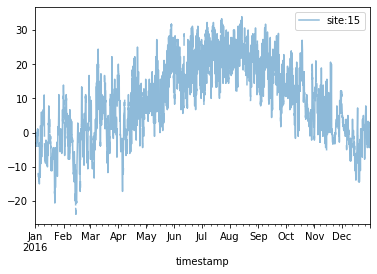

In [20]:
#weather.timestamp = weather.timestamp - datetime.timedelta(365)
#start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 9)
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
# site with largest amount of missing data points
site_id = wmatrix.count().idxmin() # Without site_id we have duplicate timestamps (readings per site), and so we cant use timestamp as an index
_ = wmatrix.loc[:, site_id].plot(label=f'site:{site_id}', alpha=0.5)
#_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2018 site:{site_id}', alpha=0.5)
#_ = wmatrix.plot(ax=ax, alpha=0.5)
_ = plt.legend()

Missing vals are only 55, so not clear over a long period
Let's split and show only a small period

In [21]:
wmatrix

site_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
timestamp,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,25.0,3.8,15.6,10.0,NaN,NaN,NaN,-1.8,25.0,NaN,NaN,-1.8,1.9,-8.3,NaN,NaN
2016-01-01 01:00:00,24.4,3.7,13.9,9.4,9.4,5.0,10.0,-1.7,24.4,10.0,-10.6,-1.7,1.6,-8.3,5.6,-1.0
2016-01-01 02:00:00,22.8,2.6,13.3,8.9,8.3,3.0,10.0,-2.7,22.8,10.0,-11.1,-2.7,0.7,-7.8,5.6,-1.0
2016-01-01 03:00:00,21.1,2.0,12.2,7.8,7.8,4.0,9.4,-2.3,21.1,10.0,-10.0,-2.3,0.8,-7.8,5.6,-1.0
2016-01-01 04:00:00,20.0,2.3,11.7,7.8,5.0,4.0,7.8,-2.6,20.0,10.0,-13.3,-2.6,2.9,-7.2,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,22.8,8.1,15.0,9.4,12.8,9.0,8.9,-10.3,22.8,21.7,-4.4,-10.3,9.7,-3.3,6.7,3.0
2016-12-31 20:00:00,23.3,7.2,16.1,8.9,11.1,8.0,8.9,-9.9,23.3,21.7,-4.4,-9.9,9.7,-3.9,5.6,2.8
2016-12-31 21:00:00,23.3,6.9,16.7,8.9,11.1,8.0,8.9,-9.9,23.3,23.9,-4.4,-9.9,8.6,-4.4,5.6,2.8


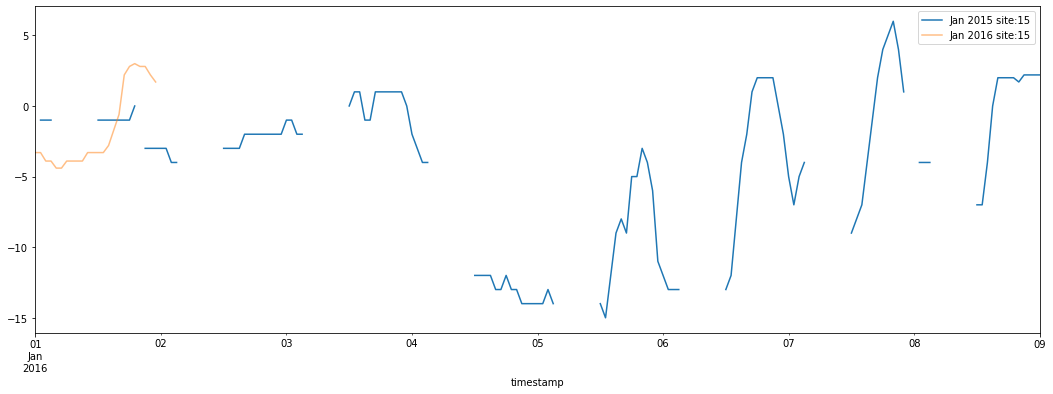

In [22]:
import datetime
# pivot to plot
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
# site with largest amount of missing data points
site_id = wmatrix.count().idxmin()
# plot perid
#start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)
start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 9)
f,ax = plt.subplots(figsize=(18,6))
_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2015 site:{site_id}')

# load test data 2017-2018
weather = pd.read_csv(weather_train_path, parse_dates=['timestamp'])

# shift 2017 to 2016
weather.timestamp = weather.timestamp - datetime.timedelta(365)
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2016 site:{site_id}', alpha=0.5)

'''
# load test data 2017-2018
#weather = pd.read_csv(weather_train_path, parse_dates=['timestamp'])

# shift 2018 to 2016
weather.timestamp = weather.timestamp - datetime.timedelta(365)
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2018 site:{site_id}', alpha=0.5)
'''
_ = plt.legend()

Let's fill with different interpolations

In [7]:
#load training data 2015
weather = pd.read_csv(weather_train_path, parse_dates=['timestamp'])
# pivot to plot
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
# site with largest amount of missing data points
site_id = wmatrix.count().idxmin()
# plot perid
start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 9)
f,ax = plt.subplots(figsize=(18,6))


# def fill_with_avg(wmatrix, w=12):
#     return wmatrix.fillna(wmatrix.rolling(window=w, win_type='gaussian', center=True, min_periods=1).mean(std=2))

def fill_with_po3(wmatrix):
    return wmatrix.fillna(wmatrix.interpolate(method='polynomial', order=3))

def fill_with_lin(wmatrix):
    return wmatrix.fillna(wmatrix.interpolate(method='linear'))

def fill_with_mix(wmatrix):
    wmatrix = (wmatrix.fillna(wmatrix.interpolate(method='linear', limit_direction='both')) +
               wmatrix.fillna(wmatrix.interpolate(method='polynomial', order=3, limit_direction='both'))
              ) * 0.5
    # workaround: fill last NANs with neighbour
    assert wmatrix.count().min() >= len(wmatrix)-1 # only the first item is missing
    return wmatrix.fillna(wmatrix.iloc[1])         # fill with second item


_ = fill_with_lin(wmatrix).loc[start_date:end_date, site_id].plot(ax=ax, label=f'linear Jan 2016 site:{site_id}', alpha=0.5)
_ = fill_with_po3(wmatrix).loc[start_date:end_date, site_id].plot(ax=ax, label=f'cubic Jan 2016 site:{site_id}', alpha=0.5)
_ = fill_with_mix(wmatrix).loc[start_date:end_date, site_id].plot(ax=ax, label=f'mix Jan 2016 site:{site_id}', alpha=0.5)
_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2016 site:{site_id}')

_ = plt.legend()

NameError: ignored

No big differences, let's use the mix method


Now, let's fill the weather then merge to train_df

In [0]:
def fill_temps(weather):
    df = None
    for col in ['air_temperature', 'dew_temperature']:
        filled = fill_with_mix(weather.pivot(index='timestamp', columns='site_id', values=col))
        filled = filled.sort_index().unstack().to_frame(col)
        if df is None:
            df = filled
        else:
            df[col] = filled[col]
    return df

In [0]:
weather = pd.read_csv(weather_train_path, parse_dates=['timestamp'])

In [26]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [27]:
description(weather)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int64,0,16,0,0,0
1,timestamp,datetime64[ns],0,8784,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00
2,air_temperature,float64,55,619,25,24.4,22.8
3,cloud_coverage,float64,69173,10,6,NaN,2
4,dew_temperature,float64,113,522,20,21.1,21.1
5,precip_depth_1_hr,float64,50289,128,NaN,-1,0
6,sea_level_pressure,float64,10618,709,1019.7,1020.2,1020.2
7,wind_direction,float64,6268,43,0,70,0
8,wind_speed,float64,304,58,0,1.5,0


In [0]:
wf = fill_temps(weather)
wf = wf.reset_index().merge(weather[['site_id', 'timestamp', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']],
                        how='left', on=['site_id', 'timestamp'])#.set_index(['site_id', 'timestamp'])
for col in ['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']:
    wf.loc[wf[col] < 0, col] = 0
    wf.fillna(0, inplace=True)



In [29]:
description(wf)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,site_id,int64,0,16,0,0,0
1,timestamp,datetime64[ns],0,8784,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00
2,air_temperature,float64,0,1265,25,24.4,22.8
3,dew_temperature,float64,0,1203,20,21.1,21.1
4,cloud_coverage,float64,0,10,6,0,2
5,precip_depth_1_hr,float64,0,127,0,0,0
6,wind_direction,float64,0,43,0,70,0
7,wind_speed,float64,0,58,0,1.5,0


In [30]:
wf.head()

,site_id,timestamp,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,20.0,6.0,0.0,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,21.1,0.0,0.0,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,21.1,2.0,0.0,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,20.6,2.0,0.0,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,20.0,2.0,0.0,250.0,2.6


In [0]:
weather = wf

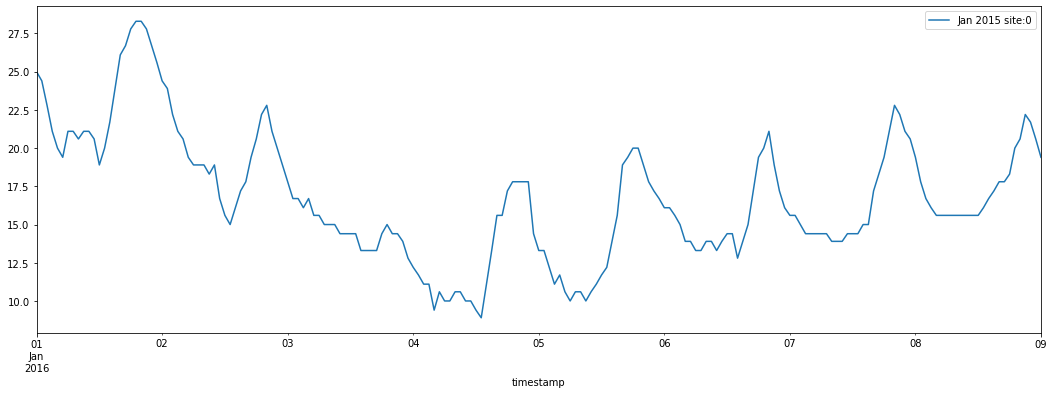

In [32]:
import datetime
# pivot to plot
wmatrix = weather.pivot(index='timestamp', columns='site_id', values='air_temperature')
# site with largest amount of missing data points
site_id = wmatrix.count().idxmin()
# plot perid
#start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)
start_date, end_date = datetime.date(2016, 1, 1), datetime.date(2016, 1, 9)
f,ax = plt.subplots(figsize=(18,6))
_ = wmatrix.loc[start_date:end_date, site_id].plot(ax=ax, label=f'Jan 2015 site:{site_id}')

_ = plt.legend()

Let's wrap everything in a function

In [0]:
def fill_with_po3(wmatrix):
    return wmatrix.fillna(wmatrix.interpolate(method='polynomial', order=3))

def fill_with_lin(wmatrix):
    return wmatrix.fillna(wmatrix.interpolate(method='linear'))

def fill_with_mix(wmatrix):
    wmatrix = (wmatrix.fillna(wmatrix.interpolate(method='linear', limit_direction='both')) +
               wmatrix.fillna(wmatrix.interpolate(method='polynomial', order=3, limit_direction='both'))
              ) * 0.5
    # workaround: fill last NANs with neighbour
    assert wmatrix.count().min() >= len(wmatrix)-1 # only the first item is missing
    return wmatrix.fillna(wmatrix.iloc[1])         # fill with second item
def fill_temps(weather):
    df = None
    for col in ['air_temperature', 'dew_temperature']:
        filled = fill_with_mix(weather.pivot(index='timestamp', columns='site_id', values=col))
        filled = filled.sort_index().unstack().to_frame(col)
        if df is None:
            df = filled
        else:
            df[col] = filled[col]
    return df
def fill_missing_temps(weather):
  wf = fill_temps(weather)
  wf = wf.reset_index().merge(weather[['site_id', 'timestamp', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']],
                          how='left', on=['site_id', 'timestamp'])#.set_index(['site_id', 'timestamp'])
  for col in ['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']:
      wf.loc[wf[col] < 0, col] = 0
      wf.fillna(0, inplace=True)  
  return wf

In [9]:

def load_train_data():
  if kaggle:
    train_path = '/kaggle/input/ashrae-energy-prediction/train.csv'
    building_train_path = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
    weather_train_path = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
  else:
    train_path = 'train.csv'
    building_train_path = 'building_metadata.csv'
    weather_train_path = 'weather_train.csv'

  return pd.merge(pd.merge(pd.read_csv(train_path, parse_dates=['timestamp']), pd.read_csv(building_train_path), on='building_id', how='left'), fill_missing_temps(pd.read_csv(weather_train_path, parse_dates=['timestamp'])), on=['timestamp','site_id'], how='left')
train_df = load_train_data()
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0


In [12]:
train_df.dtypes

building_id                   int64
meter                         int64
timestamp            datetime64[ns]
meter_reading               float64
site_id                       int64
primary_use                  object
square_feet                   int64
year_built                  float64
floor_count                 float64
air_temperature             float64
dew_temperature             float64
cloud_coverage              float64
precip_depth_1_hr           float64
wind_direction              float64
wind_speed                  float64
dtype: object

In [18]:
train_df.timestamp.dtype

dtype('<M8[ns]')

In [20]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 2217.15 MB
Memory usage after optimization is: 752.28 MB
Decreased by 66.1%


In [21]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,0,1162,25,25,25


In [0]:
import lightgbm as lgb

In [0]:
y_train = train_df.meter_reading

Note that: LGBM will ignore missing values in the features vector.
https://www.kaggle.com/c/home-credit-default-risk/discussion/57918

semissing=false, which disables handling for missing values. You can also use the zeroas_missing option to change behavior.

So we need to handle missing values for better performance. Especially for __temprature values__

In [0]:
features = ['meter',
            'site_id',
            'building_id',
            'primary_use',
            'square_feet',
            #'year_built',
            #'floor_count',
            #'air_temperature',
            #'dew_temperature',
            #'cloud_coverage',
            #'wind_direction',
            #'wind_speed',
            #'precip_depth_1_hr',
            #'hour',
            #'weekday',
            #'day',
            'month',
            'season'
            ] # meter must be added, since not all features corr to meter_reading are the same. Same for site_id with less priority
def select_features(df):    
    return df[features] 

In [0]:

x_train = select_features(train_df)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def prep_features(dataset):
    features = []; categorical_features = []
    num_of_columns = dataset.shape[1]
 
    for i in range(0, num_of_columns):
        column_name = dataset.columns[i]
        column_type = dataset[column_name].dtypes
        '''
        if i != num_of_columns - 1: #skip target
            features.append(column_name)
        '''
        features.append(column_name)
        if column_type == 'object':
            le.fit(dataset[column_name])
            feature_classes = list(le.classes_)
            encoded_feature = le.transform(dataset[column_name])
            dataset[column_name] = pd.DataFrame(encoded_feature)
            '''
            if i != num_of_columns - 1: #skip target
                categorical_features.append(column_name)
            '''
            categorical_features.append(column_name)
    '''
    if is_regression == False and i == num_of_columns - 1:
        num_of_classes = len(feature_classes)
    else:
        num_of_classes = 1
    '''
    return dataset, features, categorical_features

In [0]:

x_train, features, categorical_features = prep_features(x_train)

In [0]:
from sklearn.model_selection import KFold, train_test_split
# Make validation set based on train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [0]:
lgb_train = lgb.Dataset(x_train, y_train
 ,feature_name = features#+categorical_features
 #, categorical_feature = categorical_features
)

In [0]:
params = {
 'task': 'train'
 , 'boosting_type': 'gbdt'
 , 'objective': 'regression'# if is_regression == True else 'multiclass'
 , 'num_class': 1
 , 'metric': 'rmsle'# if is_regression == True else 'multi_logloss'
 , 'min_data': 1
 , 'verbose': 1
}
 
gbm = lgb.train(params, lgb_train, num_boost_round=50)

In [0]:
!pip install graphviz

import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()
 
ax = lgb.plot_tree(gbm)
plt.show()

In [0]:
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
y_pred = gbm.predict(x_val)
score = np.sqrt(mse(y_val, y_pred))# we use mse not msle since we already make y_val as np.log1p and so the y_pred
print('Val MSE = ', score)

In [0]:
del train_df
del x_train
del x_val

In [0]:
def load_test_data():
  if kaggle:
    test_path = '/kaggle/input/ashrae-energy-prediction/test.csv'
    weather_test_path = '/kaggle/input/ashrae-energy-prediction/weather_test.csv'
    building_train_path = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
  else:
    test_path = 'test.csv'
    weather_test_path = 'weather_test.csv'    
    building_train_path = 'building_metadata.csv'
    
  
  return pd.merge(pd.merge(pd.read_csv(test_path), pd.read_csv(building_train_path), on='building_id', how='left'), pd.read_csv(weather_test_path), on=['timestamp','site_id'], how='left')

In [0]:

if not kaggle:
  !unzip -n test.csv.zip
  !unzip -n weather_test.csv.zip
  
test_df = load_test_data()
# Test prep and features extraction


test_df = reduce_mem_usage(test_df)

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df["hour"] = test_df["timestamp"].dt.hour
test_df["day"] = test_df["timestamp"].dt.day
test_df["weekday"] = test_df["timestamp"].dt.weekday_name 
test_df["month"] = test_df["timestamp"].dt.month
test_df['year'] = test_df['timestamp'].dt.year

test_df['season'] = test_df.month.apply(month_to_season)
#test_df = reduce_mem_usage(test_df)

x_test = select_features(test_df)
del test_df
x_test, features, categorical_features = prep_features(x_test)

The score predicts to return the abs meter reading, while we predict log(p) + 1. So we must make exp(pred) - 1.

This is all done using np.expm1 (m1 = minus 1)

In [0]:
preds = np.expm1(gbm.predict(x_test))

In [0]:
#!unzip -n sample_submission.csv.zip
if kaggle:
  sample = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
else:
  !unzip -n sample_submission.csv.zip
  sample = pd.read_csv("sample_submission.csv")
sample['meter_reading'] = preds #np.expm1(gbm.predict(x_test))
sample.to_csv('submission.csv', index=False)
sample.head()